# Statistics and Data Manipulation
([Back to Overview](../index.html#/0/4))

In [2]:
using Plots
default(fmt=:png, dpi=300)

## Aside: Piping, Mapping, and Filtering

In [3]:
import Base: filter, map
filter(f::Function)::Function = x -> filter(f, x)
map(f::Function)::Function    = x -> map(f, x)

map (generic function with 67 methods)

In [4]:
x = collect(range(0, 10))

11-element Vector{Int64}:
  0
  1
  2
  3
  4
  5
  6
  7
  8
  9
 10

In [5]:
x |> map(x->x+1)

11-element Vector{Int64}:
  1
  2
  3
  4
  5
  6
  7
  8
  9
 10
 11

In [6]:
x |> map(x->x+1) |> filter(x->x%2==0)

5-element Vector{Int64}:
  2
  4
  6
  8
 10

## Statistics and Feature Extraction

In [7]:
using Dates
using TimeZones
using MySQL
using DataFrames
using JSON

import Base: @kwdef

data_directory = joinpath(@__DIR__, "..", "..", "..", "exercises", "fridge")

timestamp(t; target_tz::VariableTimeZone=tz"America/Los_Angeles") = astimezone(
    ZonedDateTime(Dates.unix2datetime(t), tz"GMT"), target_tz
)

function get_emeter_data(conn::MySQL.Connection, name::String, idx::Int64)
    DBInterface.execute(
        DBInterface.prepare(conn,
            "SET @v1 := (SELECT emeter_start FROM $(name) WHERE idx = $(idx))"
        )
    )
    DBInterface.execute(
        DBInterface.prepare(conn,
            "SET @v2 := (SELECT emeter_end FROM $(name) WHERE idx = $(idx))"
        )
    )
    events = DBInterface.execute(
        DBInterface.prepare(conn,
            "SELECT * FROM $(name)_emeter WHERE idx BETWEEN @v1 and @v2"
        )
    ) |> DataFrame
    events = transform(
        events,
        :t => (x->timestamp.(x)) => :timestamp
    )
    return events
end

@kwdef mutable struct DBCredentials
    host::String
    name::String
    username::String
    password::String
end

db_credenitals = DBCredentials(
    ;JSON.parsefile(
        joinpath(data_directory, "db.json"),
        dicttype=Dict{Symbol,String}
    )...
)
# db_credenitals.host = "127.0.0.1";

db_conn = DBInterface.connect(
    MySQL.Connection, db_credenitals.host,
    db_credenitals.username, db_credenitals.password,
    db=db_credenitals.name
)

name = "Arstotzka_Ministry_of_Energy"
idx_max = 61
idx_blacklist = [
    1,2,3,4,5,6,7,8,9,  # Debugging
    51  #  Battery Charger
]

all_emeter_data = DataFrame[]

for idx=1:idx_max
    if idx in idx_blacklist
        continue
    end
    push!(all_emeter_data, get_emeter_data(db_conn, name, idx))
end

all_emeter_data = vcat(all_emeter_data...);

In [8]:
describe(all_emeter_data)

,variable,mean,min,median,max
,Symbol,Union…,Any,Union…,Any
1,idx,2.4833e6,12,2.48353e6,4958709
2,t,1.6465e9,1.64349e9,1.6465e9,1.64955e9
3,ma,414.049,0,60.0,9012
4,mv,1.21104e5,106168,121184.0,124168
5,mw,45782.7,6466,7246.0,918210
6,wh,14888.4,0,12321.0,37943
7,timestamp,,2022-01-29T12:19:41.336-08:00,,2022-04-09T17:29:25.218-07:00


In [9]:
all_emeter_data[end,:]

,idx,t,ma,mv,mw,wh,timestamp
,Int32,Float64?,Int32?,Int32?,Int32?,Int32?,ZonedDat…
4950350,4958709,1.64955e9,59,120037,7106,25200,2022-04-09T17:29:25.218-07:00


In [10]:
data = @view all_emeter_data[end-Int(2e5):end, :]

,idx,t,ma,mv,mw,wh,timestamp
,Int32,Float64?,Int32?,Int32?,Int32?,Int32?,ZonedDat…
1,4758709,1.64929e9,60,121604,7243,21087,2022-04-06T17:06:07.072-07:00
2,4758710,1.64929e9,60,121604,7293,21087,2022-04-06T17:06:08.072-07:00
3,4758711,1.64929e9,60,121604,7293,21087,2022-04-06T17:06:09.074-07:00
4,4758712,1.64929e9,60,121604,7293,21087,2022-04-06T17:06:10.075-07:00
5,4758713,1.64929e9,60,121559,7293,21087,2022-04-06T17:06:11.077-07:00
6,4758714,1.64929e9,60,121559,7293,21087,2022-04-06T17:06:12.078-07:00
7,4758715,1.64929e9,60,121559,7315,21087,2022-04-06T17:06:13.079-07:00
8,4758716,1.64929e9,60,121559,7315,21087,2022-04-06T17:06:14.081-07:00
9,4758717,1.64929e9,60,121559,7315,21087,2022-04-06T17:06:15.082-07:00


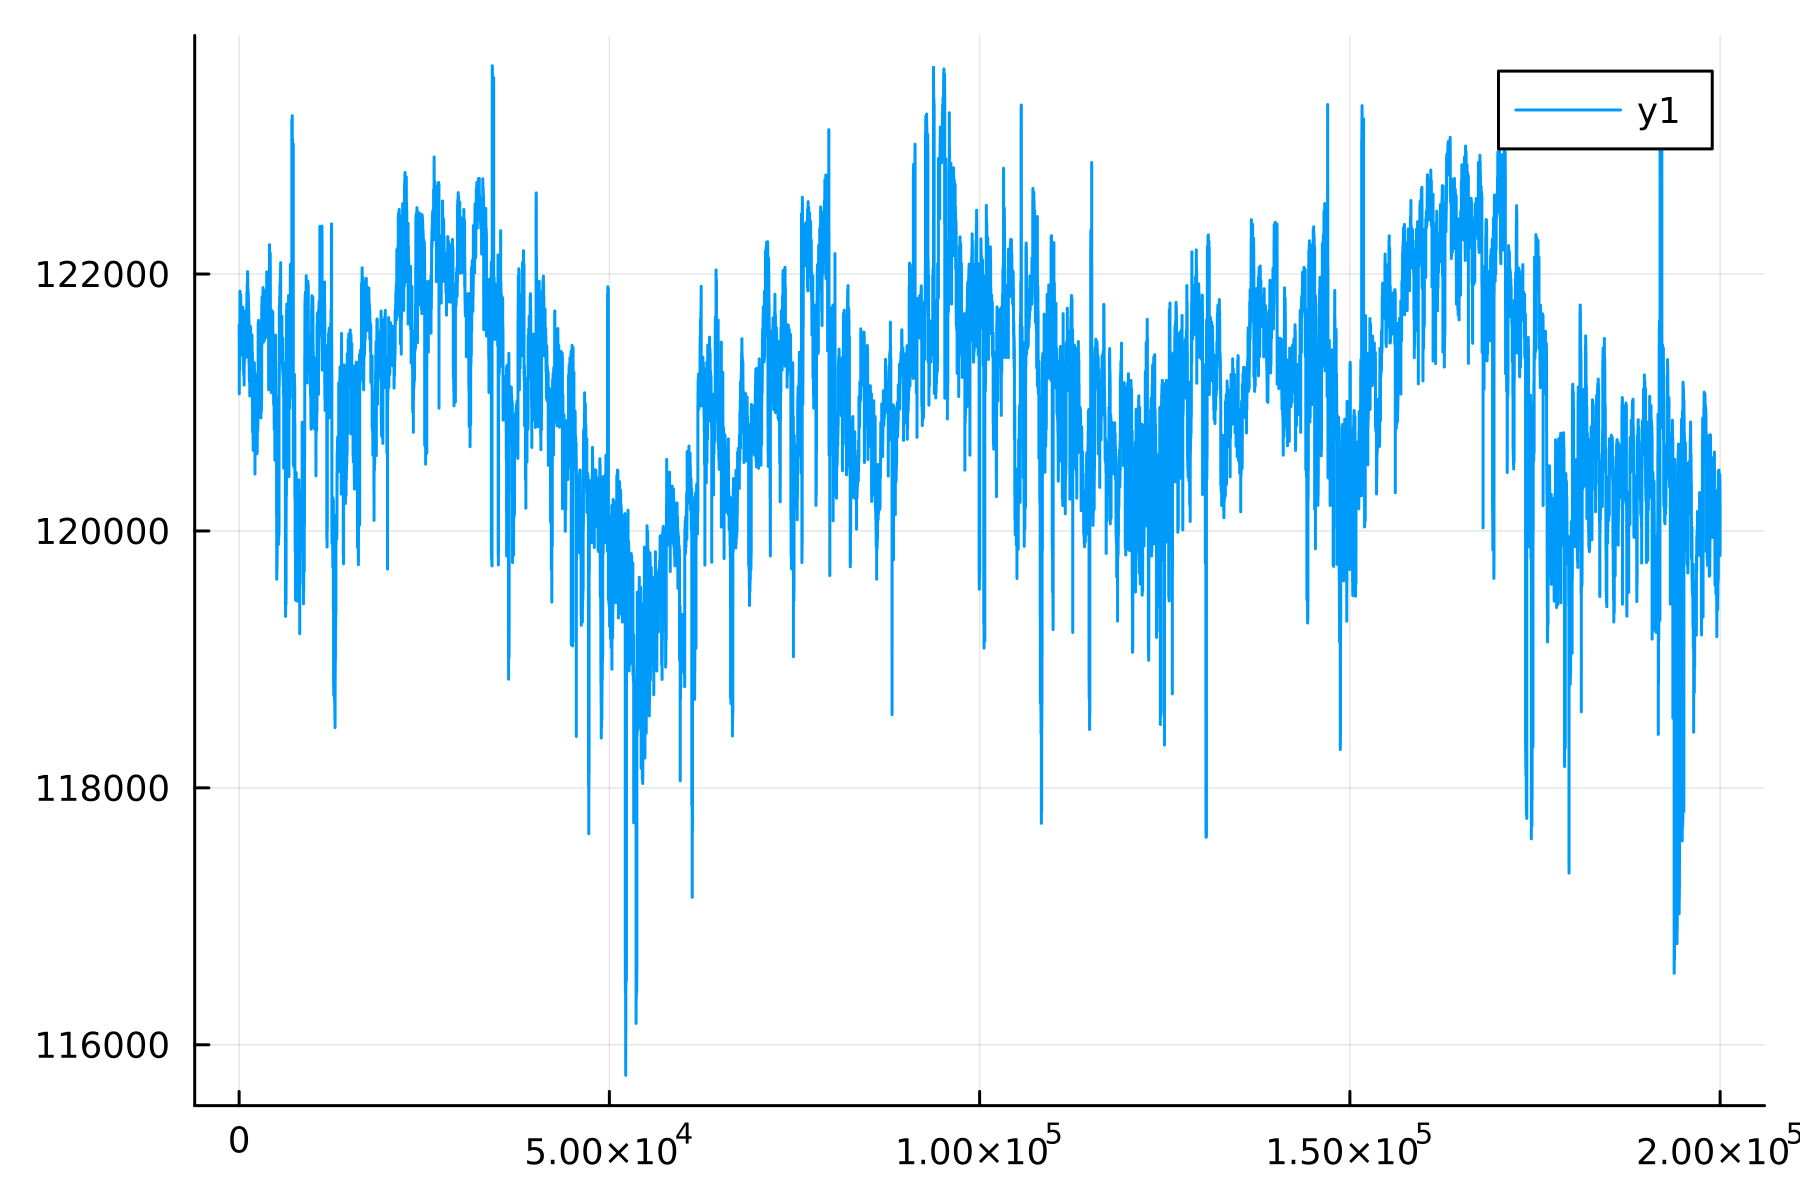

In [14]:
plot(data[:, :mv])

In [15]:
using StatsBase, LinearAlgebra

t = @view all_emeter_data[!, :mv]
h = fit(Histogram, t, 1:8:maximum(t))
h = normalize(h, mode=:density)

Histogram{Float64, 1, Tuple{StepRange{Int64, Int64}}}
edges:
  1:8:124161
weights: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.875, 0.0, 0.625, 0.75, 0.0, 0.0, 0.0, 0.0]
closed: left
isdensity: true

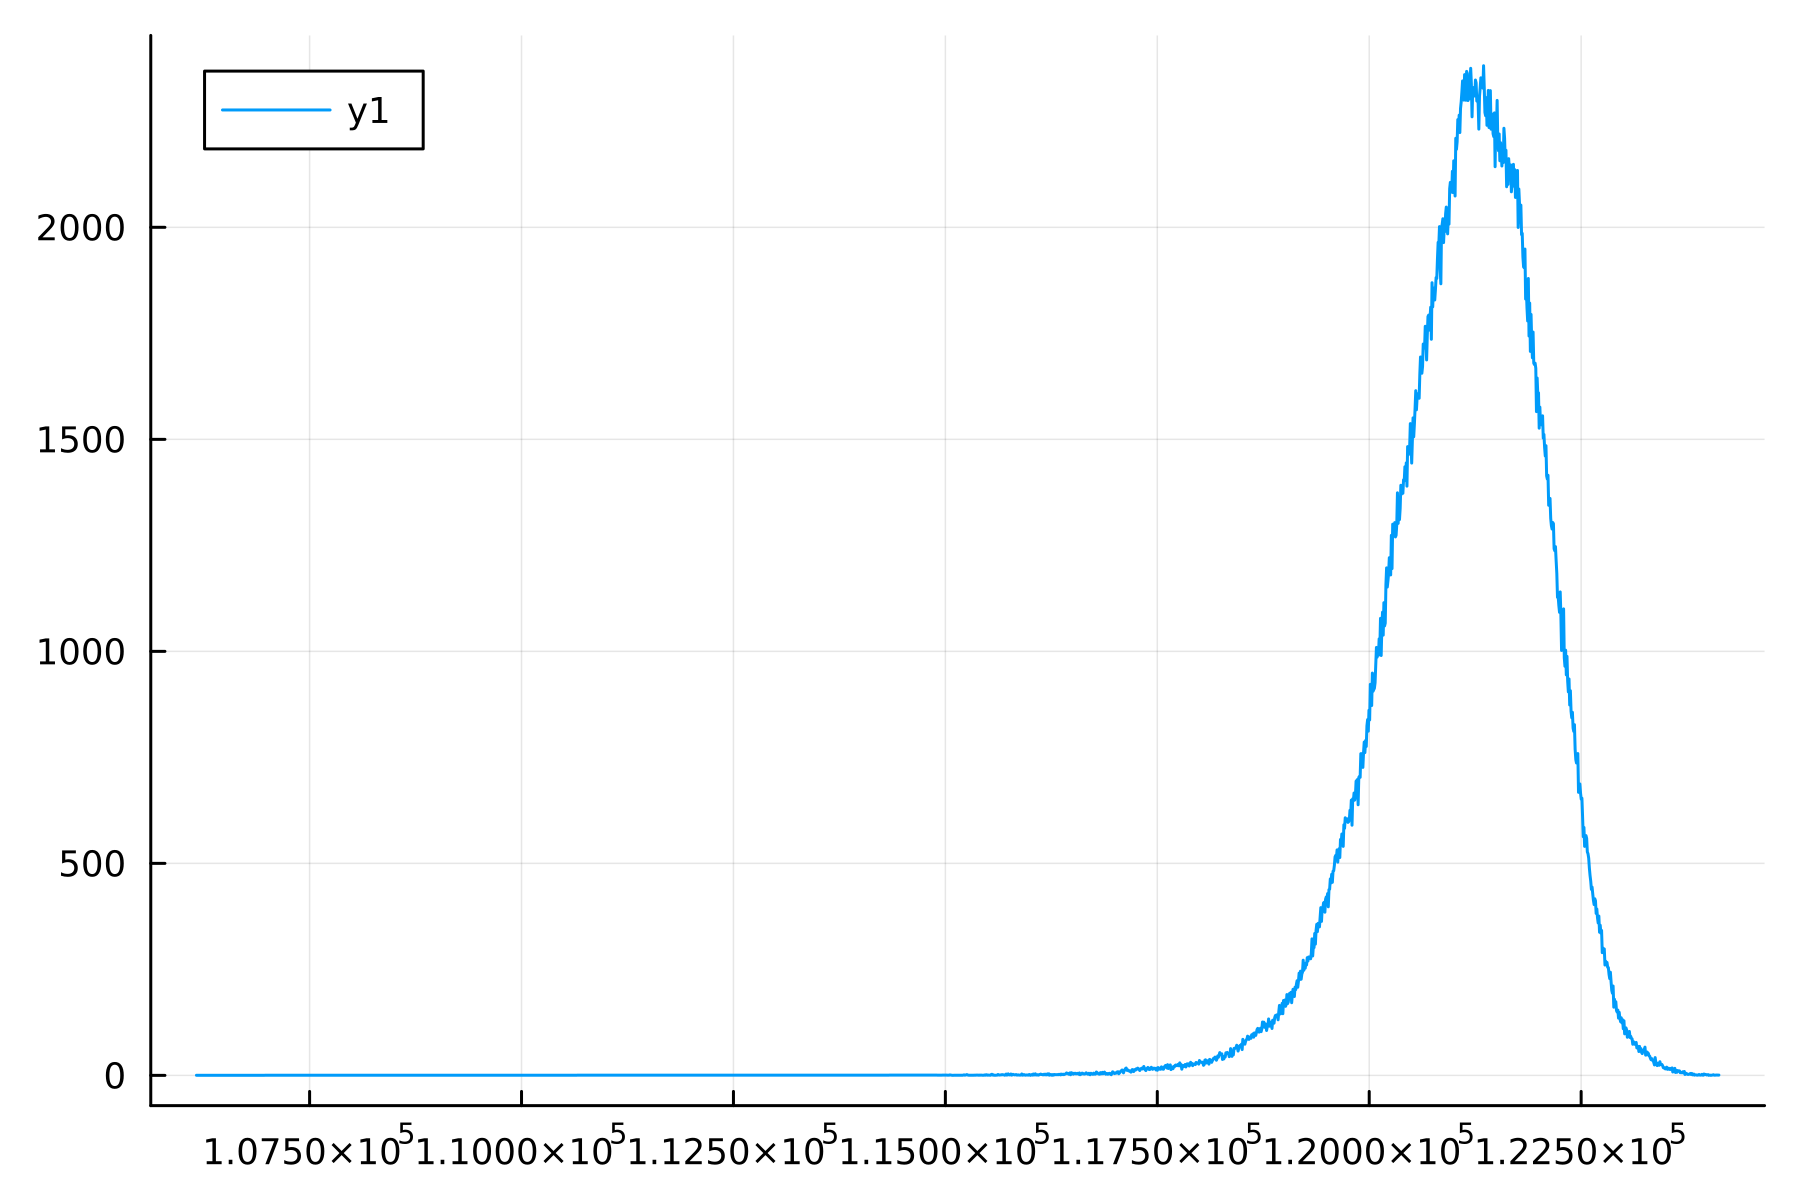

In [16]:
e = collect(h.edges[1])
x = e[1:end-1] + diff(e)/2
y = h.weights
plot(x[y.>0], y[y.>0], legend=:topleft)

For interactive feature extraction, explore `exercises/fridge/Analyze Fridge.ipynb` notebook on [GitHub](https://github.com/JBlaschke/HPC-Julia/blob/main/exercises/fridge/Analyze%20Fridge.ipynb)